# **Graded Challenge 7**

`This notebook is made to predict bone fracture based on the Bone Fracture Binary Classification Data by comparing and improving the Sequential and Functional ANN Model`

By : **M. Arindra Jehan** (HCK-015)

## i. **Libraries**

In [1]:
# Import Libraries

# Library Image
import os
from PIL import Image

# Library Data
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

# Library Model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report


# Library Model Saving
import joblib

# To Ignore Warning
import warnings
warnings.filterwarnings("ignore")

## ii. **Data Loading**

In [2]:
# Directory
main_dir = '/tmp/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train'

# Train directory
train_0 = '/tmp/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/fractured'
train_1 = '/tmp/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/not fractured'

# Test directory
test_0 = '/tmp/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/fractured'
test_1 = '/tmp/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/not fractured'

# Val directory
val_0 = '/tmp/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/fractured'
val_1 = '/tmp/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/not fractured'

**description** :

File directory of train, test, and validation image data

In [3]:
# Data Scaling
train_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)
val_datagen = ImageDataGenerator(rescale=1./255.)

# Make train data from directory
train_gen = train_datagen.flow_from_directory(
	"/tmp/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train",
	target_size=(150,150),
	class_mode='binary',
  batch_size=126,
	shuffle=True,
    seed=2
)

# Make test data from directory
test_gen = test_datagen.flow_from_directory(
	"/tmp/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test",
	target_size=(150,150),
	class_mode='binary',
  batch_size=126,
	shuffle=True,
    seed=2
)

# Make validation data from directory
val_gen = val_datagen.flow_from_directory(
	"/tmp/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val",
	target_size=(150,150),
	class_mode='binary',
  batch_size=126,
	shuffle=True,
    seed=2
)

Found 9240 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 823 images belonging to 2 classes.


**description** :

Generate batches of images and corresponding label from the train, test, and validation directory with some parameter :
- Resize image to 150x150 for **computational and memory efficiency**
- The labels will be binary (1,0) : **fractured bone and non-fractured bone**
- Set batch size to 126 (prime number) to **improve the randomness of the sampling and reduce the correlation between samples in the same batch**

In [4]:
# Show classes in the data
print(train_gen.class_indices)
print(test_gen.class_indices)
print(val_gen.class_indices)

{'fractured': 0, 'not fractured': 1}
{'fractured': 0, 'not fractured': 1}
{'fractured': 0, 'not fractured': 1}


**description** :

Classes in train, test, and validation data

## iii. **EDA**

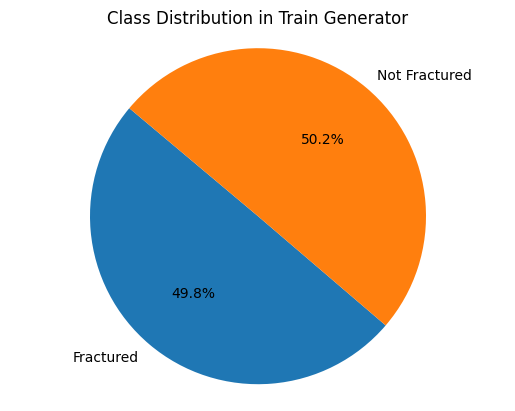

In [5]:
# Extract the class labels from the generator
class_labels = train_gen.classes

# Count the number of occurrences of each class label
class_counts = np.bincount(class_labels)

# Create a pie chart of the class counts
plt.pie(class_counts, labels=["Fractured", "Not Fractured"], autopct='%1.1f%%', startangle=140)
plt.axis("equal")
plt.title("Class Distribution in Train Generator")
plt.show()

**description** :

Figure above shows a `balanced` distribution of image in the train set, with :
- **50.2%** of non-fractured bone images
- **49.8%** of fractured bone images

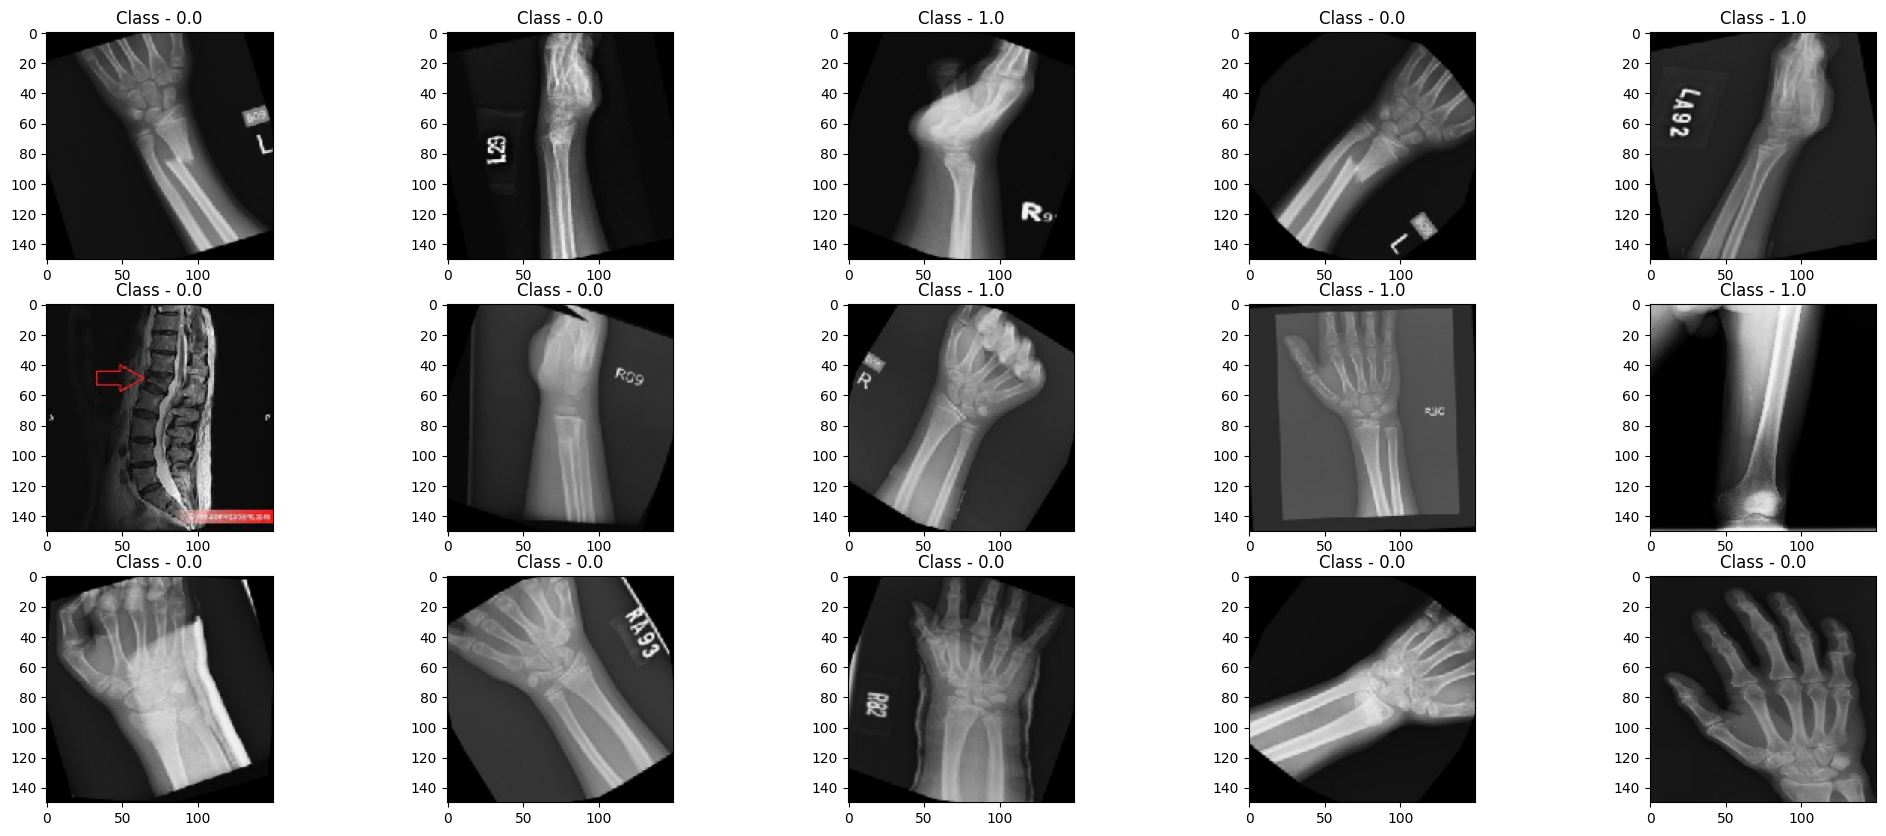

In [6]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(25,10))
n = 0

for i in range(3):
  for j in range(5):
    img = train_gen[0][0][n]
    ax[i][j].imshow(img)
    ax[i][j].set_title('Class - ' + str(train_gen[0][1][n]))
    n += 1

**description** :

Figure above shows some random images from the train set, with :
- Class 0.0 : Fractured Bone
- Class 1.0 : Non-Fractured Bone

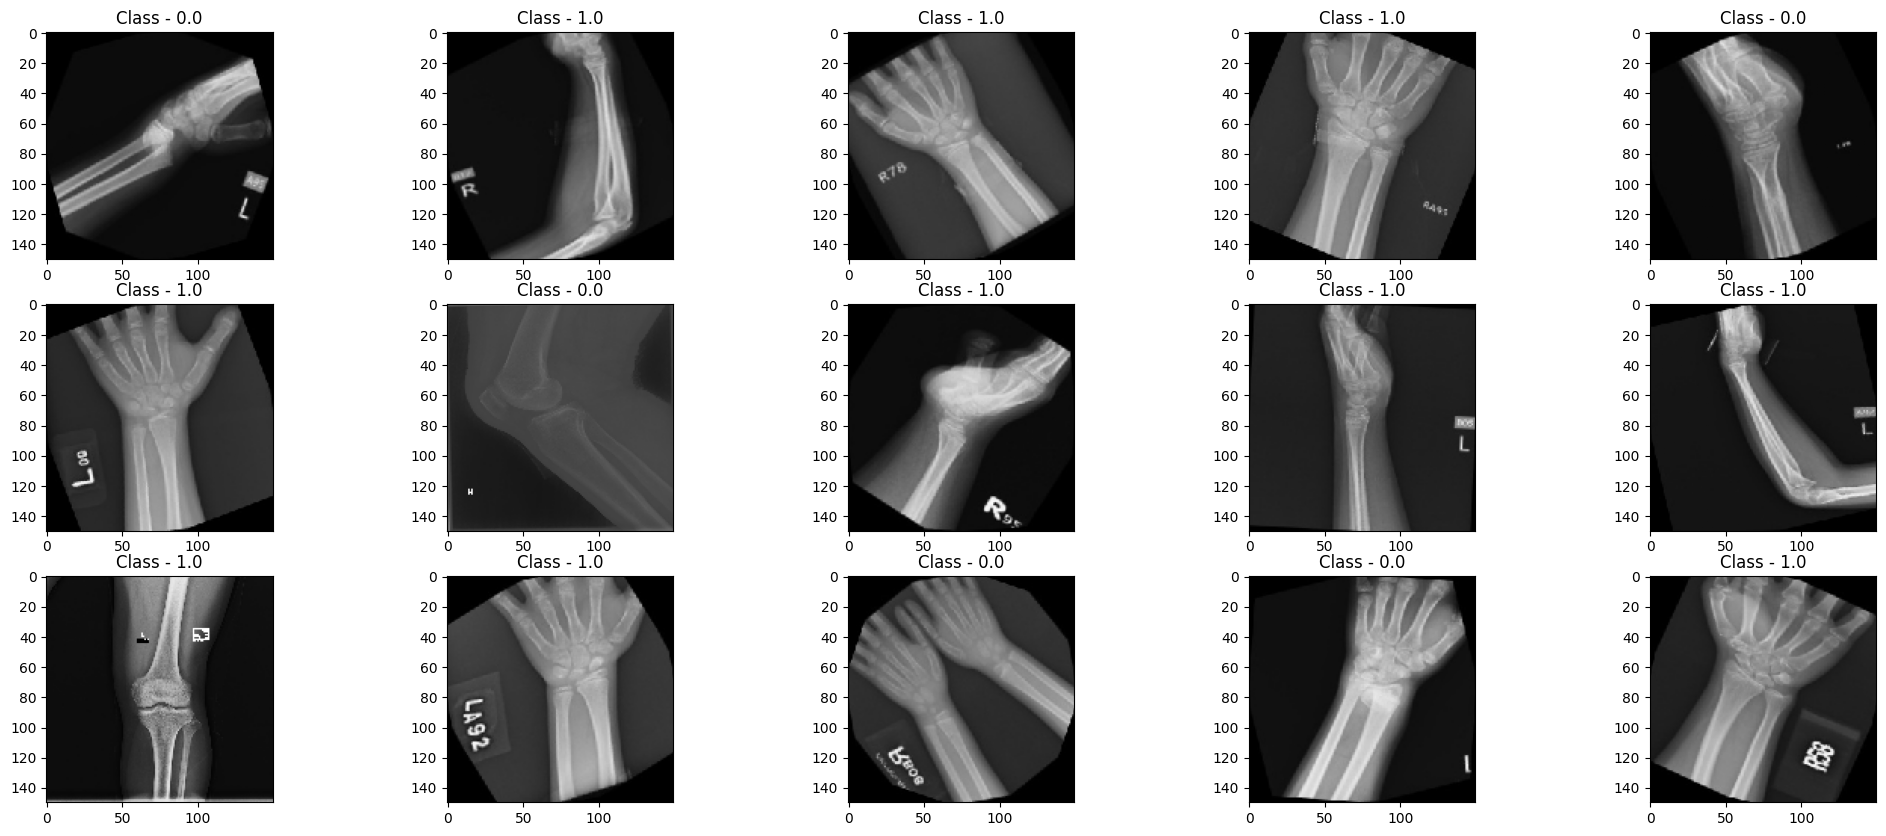

In [7]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(25,10))
n = 0

for i in range(3):
  for j in range(5):
    img = test_gen[0][0][n]
    ax[i][j].imshow(img)
    ax[i][j].set_title('Class - ' + str(test_gen[0][1][n]))
    n += 1

**description** :

Figure above shows some random images from the test set, with :
- Class 0.0 : Fractured Bone
- Class 1.0 : Non-Fractured Bone

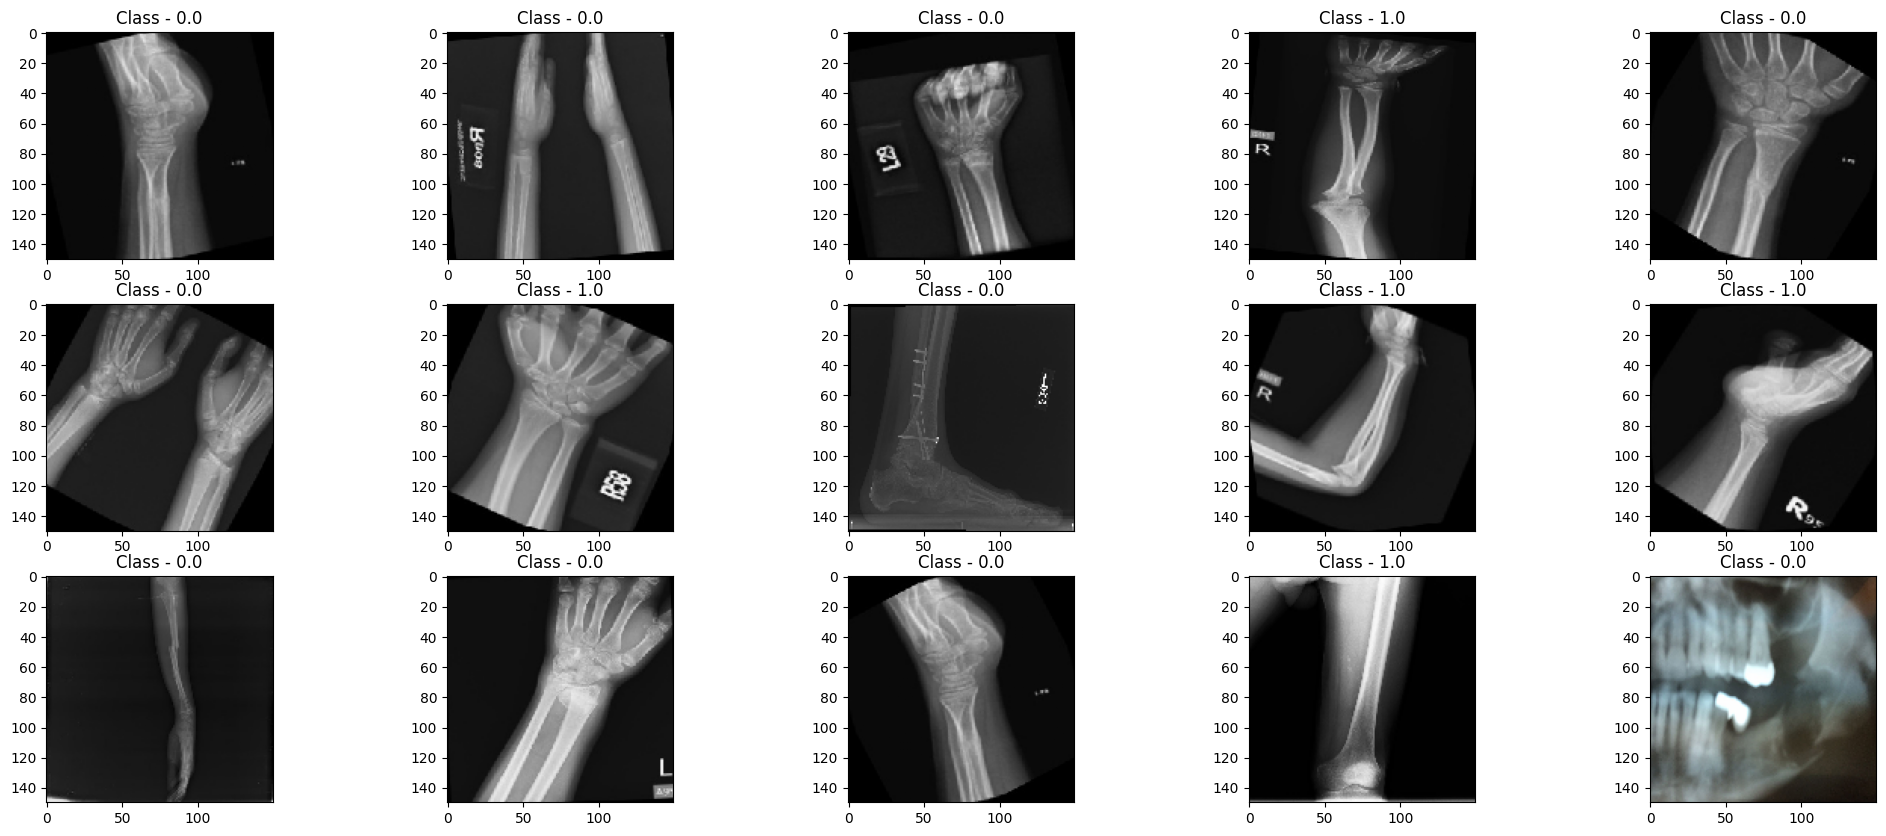

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(25,10))
n = 0

for i in range(3):
  for j in range(5):
    img = val_gen[0][0][n]
    ax[i][j].imshow(img)
    ax[i][j].set_title('Class - ' + str(val_gen[0][1][n]))
    n += 1

**description** :

Figure above shows some random images from the validation set, with :
- Class 0.0 : Fractured Bone
- Class 1.0 : Non-Fractured Bone

---

**summary** :

From the 3 figure above we can see that there are many different picture from each set, this may help to evaluate the model better in predicting the images

## iv. **Feature Engineering**

In [9]:
# Function to check image readability
def check_image_readability(folder_path):
    # Make empty list
    unreadable_images = []
    readable_images = []
    
    # Loop every image from file folder
    for file_path in tf.io.gfile.glob(folder_path + '/*'):
        try:
            # Read image
            with Image.open(file_path) as img:
                img.load()
            # Append readable image into the list
            readable_images.append(file_path)

        except (IOError, Image.DecompressionBombError) as e:
            print(f"Error reading {file_path}: {e}")
            # Append unreadable image into the list
            unreadable_images.append(file_path)
            # Remove the unreadable image from the folder
            os.remove(file_path)

    # Display the number of readable images and unreadable images
    if unreadable_images:
        print("There are unreadable images")
    else:
        print("All images are readable.")
    return unreadable_images, readable_images

**description** :

Making a function to check image readability by opening each image in the file path and append it to a list of readable image. If there is an error, it will append the image to a list of unreadable image and delete it from the file path


In [10]:
# Check image readability from the fractured images in train set
unreadable_images_train_0, readable_images_train_0 = check_image_readability(train_0)
print(len(unreadable_images_train_0), len(readable_images_train_0))

All images are readable.
0 4606


**description** :

There are :
- 0 unreadable image
- 4606 readable image

In [11]:
# Check image readability from the non-fractured images in train set
unreadable_images_train_1, readable_images_train_1 = check_image_readability(train_1)
print(len(unreadable_images_train_1), len(readable_images_train_1))

All images are readable.
0 4634


**description** :

There are :
- 0 unreadable image
- 4634 readable image

In [12]:
# Check image readability from the fractured images in test set
unreadable_images_test_0, readable_images_test_0 = check_image_readability(test_0)
print(len(unreadable_images_test_0), len(readable_images_test_0))

All images are readable.
0 238


**description** :

There are :
- 0 unreadable image
- 238 readable image

In [13]:
# Check image readability from the non-fractured images in test set
unreadable_images_test_1, readable_images_test_1 = check_image_readability(test_1)
print(len(unreadable_images_test_1), len(readable_images_test_1))

All images are readable.
0 262


**description** :

There are :
- 0 unreadable image
- 262 readable image

In [14]:
# Check image readability from the fractured images in validation set
unreadable_images_val_0, readable_images_val_0 = check_image_readability(val_0)
print(len(unreadable_images_val_0), len(readable_images_val_0))

All images are readable.
0 337


**description** :

There are :
- 0 unreadable image
- 337 readable image

In [15]:
# Check image readability from the non-fractured images in test set
unreadable_images_val_1, readable_images_val_1 = check_image_readability(val_1)
print(len(unreadable_images_val_1), len(readable_images_val_1))

All images are readable.
0 486


**description** :

There are :
- 0 unreadable image
- 486 readable image

## v. Model

### **Sequential API**

#### A. **Model Definition**

**explanation** :

These are some parameters used in the model :
1. Set **input shape of 150x150** based on the image generator with **3 color channel**
2. Use **`Sequential`** model for a simple and convenient way for deep learning
3. Use **relu** activation to **mitigate the vanishing gradient** problem 
4. Add **convulation layer** of 16 and 32 to **extract low-level and complex features** from the input data
5. Add **max pooling** to reduce dimensions of the input feature maps and **extract the most important features**
6. Add **flatten** to **reshape** the output of previous layer to 1 dimensional vector
7. Add **dropout** to **prevent overfitting**
8. Add **output layer** using Dense with 1 unit and **sigmoid** activation, as it is **commonly used for binary** classification

In [16]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Determine input shape
input_shape = (150, 150, 3)

# Initialize the model
cnn_model = Sequential()

# Add input layer
cnn_model.add(Input(shape=input_shape))

# Add convolution layer
cnn_model.add(Conv2D(16, (3, 3), 1, activation='relu'))
# Add pooling layer
cnn_model.add(MaxPooling2D())
# Add another convolution layer
cnn_model.add(Conv2D(32, (3, 3), 1, activation='relu'))
# Add another pooling layer
cnn_model.add(MaxPooling2D())
# Add another convolution layer
cnn_model.add(Conv2D(16, (3, 3), 1, activation='relu'))
# Add another pooling layer
cnn_model.add(MaxPooling2D())

# Flatten the hidden layer
cnn_model.add(Flatten())

# Add dropout layer
cnn_model.add(Dropout(0.5)) 

# Add dense layer
cnn_model.add(Dense(256, activation='relu'))
# Add output layer
cnn_model.add(Dense(1, activation='sigmoid'))

# Display model summary
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4624)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4624)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,184,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,193,969 (4.55 MB)

 Trainable params: 1,193,969 (4.55 MB)

 Non-trainable params: 0 (0.00 B)

#### B. **Model Training**


**explanation** :

Compile CNN model with :
1. **`BinaryCrossentropy`** loss because the problem is a binary classification, where the model predict between 0 and 1
2. **`Adam optimizer`** because it adapts the learning rate for each parameter based on the gradient history, which can lead to a better performance
3. **`Accuracy`** metrics is used to measure the performance of the model 

Fit the model into :
1. Trains the model using the train dataset (train_gen)
2. Use 15 epochs to avoid overfitting and underfitting
3. Validate the model using the validation dataset (val_gen)

In [17]:
# Compline model loss, optimizer and metrics
cnn_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Fit model into train set
history = cnn_model.fit(train_gen, epochs=15, validation_data=val_gen)

Epoch 1/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 48s 614ms/step - accuracy: 0.7015 - loss: 0.5562 - val_accuracy: 0.8469 - val_loss: 0.3786
Epoch 2/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 46s 600ms/step - accuracy: 0.9013 - loss: 0.2639 - val_accuracy: 0.9077 - val_loss: 0.2707
Epoch 3/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 45s 582ms/step - accuracy: 0.9578 - loss: 0.1199 - val_accuracy: 0.9526 - val_loss: 0.1614
Epoch 4/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 45s 584ms/step - accuracy: 0.9831 - loss: 0.0565 - val_accuracy: 0.9623 - val_loss: 0.0978
Epoch 5/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 46s 596ms/step - accuracy: 0.9886 - loss: 0.0355 - val_accuracy: 0.9721 - val_loss: 0.0710
Epoch 6/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 47s 614ms/step - accuracy: 0.9918 - loss: 0.0250 - val_accuracy: 0.9842 - val_loss: 0.0511
Epoch 7/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 47s 606ms/step - accuracy: 0.9952 - loss: 0.0151 - val_accuracy: 0.9830 - val_loss: 0.0583
Epoch 8/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 46s 594ms/step - accuracy: 0.9950 - loss: 0.0152 - val_accu

**summary** :

* The **training accuracy increased steadily** over the 15 epochs, starting at 70.15% and reaching `99.78%` by the end of training.
* The **training loss decreased steadily** over the 15 epochs, starting at 0.6363 and reaching `0.0073` by the end of training.
* The **validation accuracy also increased steadily** over the 15 epochs, starting at 78.69% and reaching `98.78%` by the end of training.
* The **validation loss decreased initially but then fluctuated** somewhat over the 15 epochs, starting at 0.3786 and ending at `0.0548`.

Note that **the model seem to overfit** as there is a difference in the training accuracy (99.78%) and validation accuracy (98.78%), with a difference of **`1.00%`**

#### C. **Model Evaluation**

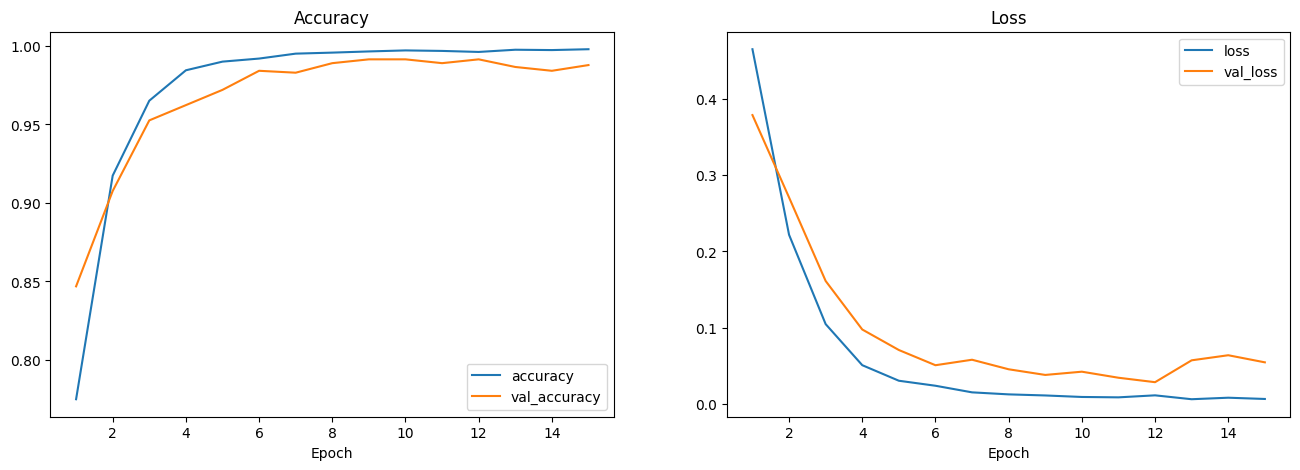

In [18]:
epoch = 15

# Make figure for subplot
fig, ax = plt.subplots(ncols=2,figsize=(16,5))

# Make plot for accuracy vs val_accuracy
ax[0].plot(range(1,epoch+1),history.history['accuracy'],label='accuracy')
ax[0].plot(range(1,epoch+1),history.history['val_accuracy'],label='val_accuracy')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epoch')

# Make plot for loss vs val_loss
ax[1].plot(range(1,epoch+1),history.history['loss'],label='loss')
ax[1].plot(range(1,epoch+1),history.history['val_loss'],label='val_loss')
ax[1].set_title('Loss')
ax[1].legend()
ax[1].set_xlabel('Epoch')

# Show figure
plt.show()

**summary** :

The low loss and high accuracy indicates **a good model performance**. The model seems to perform very well on the training data, achieving 100% accuracy at the first epoch. However, the accuracy on the validation data is lower, suggesting that **the model might be overfitting the training data**

To improve the model's performance, we can use techniques such as **regularization** and **early stopping**

In [19]:
# Predict test-set

cnn_model.evaluate(test_gen)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 860ms/step - accuracy: 0.9979 - loss: 0.0033


[0.0038025968242436647, 0.9980000257492065]

### **Functional API**

#### A. **Model Definition**

**explanation** :

These are some parameters used in the model :
1. Set **input shape of 150x150** based on the image generator with **3 color channel**
2. Use **`Functional`** model for its **model flexibility** that might lead to a better performance than sequential
3. Use **relu** activation to **mitigate the vanishing gradient** problem 
4. Add **convulation layer** of 16 and 32 to **extract low-level and complex features** from the input data
5. Add **max pooling** to reduce dimensions of the input feature maps and **extract the most important features**
6. Add **flatten** to **reshape** the output of previous layer to 1 dimensional vector
7. Add **dropout** to **prevent overfitting**
8. Add **output layer** using Dense with 1 unit and **sigmoid** activation, as it is **commonly used for binary** classification

In [20]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Determine input shape
input_shape = (150, 150, 3)

# Define input layer
inputs = Input(shape=input_shape)

# Add convolution layer
x = Conv2D(16, (3, 3), 1, activation='relu')(inputs)
# Add pooling layer
x = MaxPooling2D()(x)
# Add another convolution layer
x = Conv2D(32, (3, 3), 1, activation='relu')(x)
# Add another pooling layer
x = MaxPooling2D()(x)
# Add another convolution layer
x = Conv2D(16, (3, 3), 1, activation='relu')(x)
# Add another pooling layer
x = MaxPooling2D()(x)

# Flatten the hidden layer
x = Flatten()(x)

# Add dropout layer
x = Dropout(0.5)(x) 

# Add dense layer
x = Dense(256, activation='relu')(x)
# Add output layer
outputs = Dense(1, activation='sigmoid')(x)

# Define the model
cnn_model_2 = Model(inputs=inputs, outputs=outputs)

# Display model summary
cnn_model_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4624)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4624)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,184,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,193,969 (4.55 MB)

 Trainable params: 1,193,969 (4.55 MB)

 Non-trainable params: 0 (0.00 B)

#### B. **Model Training**

**explanation** :

Compile CNN model with :
1. **`BinaryCrossentropy`** loss because the problem is a binary classification, where the model predict between 0 and 1
2. **`Adam optimizer`** because it adapts the learning rate for each parameter based on the gradient history, which can lead to a better performance
3. **`Accuracy`** metrics is used to measure the performance of the model 

Fit the model into :
1. Trains the model using the train dataset (train_gen)
2. Use 15 epochs to avoid overfitting and underfitting
3. Validate the model using the validation dataset (val_gen)

In [21]:
# Compline model loss, optimizer and metrics
cnn_model_2.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Fit model into train set
history_2 = cnn_model_2.fit(train_gen, epochs=15, validation_data=val_gen)

Epoch 1/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 47s 593ms/step - accuracy: 0.7026 - loss: 0.5503 - val_accuracy: 0.8360 - val_loss: 0.3954
Epoch 2/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 572ms/step - accuracy: 0.9026 - loss: 0.2467 - val_accuracy: 0.9113 - val_loss: 0.2405
Epoch 3/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 573ms/step - accuracy: 0.9626 - loss: 0.1105 - val_accuracy: 0.9380 - val_loss: 0.1715
Epoch 4/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 573ms/step - accuracy: 0.9837 - loss: 0.0563 - val_accuracy: 0.9538 - val_loss: 0.1234
Epoch 5/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 571ms/step - accuracy: 0.9874 - loss: 0.0356 - val_accuracy: 0.9806 - val_loss: 0.0650
Epoch 6/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 569ms/step - accuracy: 0.9889 - loss: 0.0316 - val_accuracy: 0.9830 - val_loss: 0.0525
Epoch 7/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 576ms/step - accuracy: 0.9936 - loss: 0.0205 - val_accuracy: 0.9854 - val_loss: 0.0505
Epoch 8/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 44s 567ms/step - accuracy: 0.9945 - loss: 0.0144 - val_accu

**summary** :

* The **training accuracy increased steadily** over the 15 epochs, starting at 70.26% and reaching `99.82%` by the end of training.
* The **training loss decreased steadily** over the 15 epochs, starting at 0.5503 and reaching `0.0049` by the end of training.
* The **validation accuracy also increased steadily** over the 15 epochs, starting at 83.60% and reaching `99.39%` by the end of training.
* The **validation loss decreased initially but then fluctuated** somewhat over the 15 epochs, starting at 0.3954 and ending at `0.0321`.

Note that **the model seem to overfit** as there is a difference in the training accuracy (99.82%) and validation accuracy (99.39%), with a difference of **`0.43%`**

#### C. **Model Evaluation**

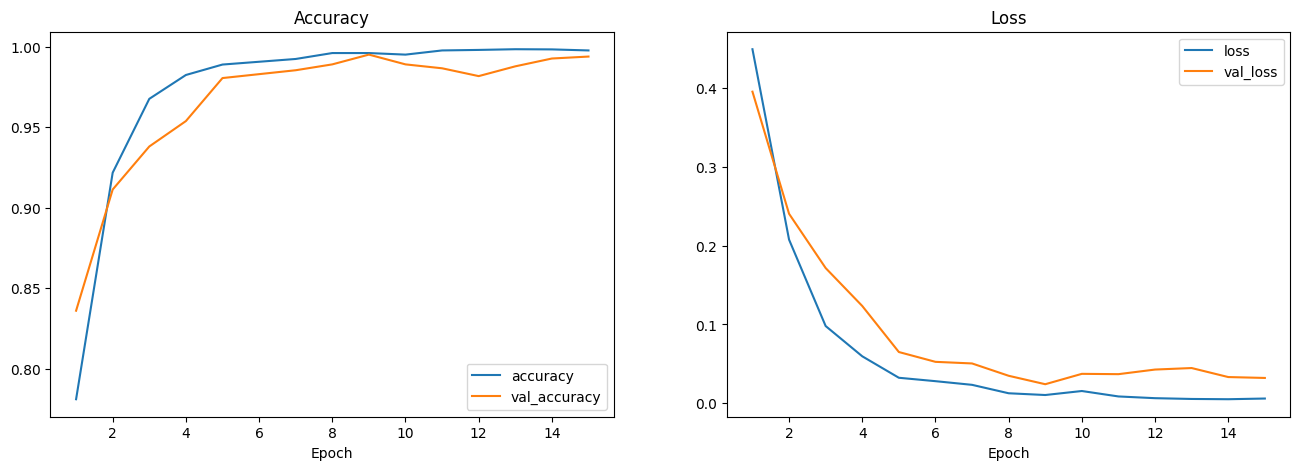

In [22]:
epoch = 15

# Make figure for subplot
fig, ax = plt.subplots(ncols=2,figsize=(16,5))

# Make plot for accuracy vs val_accuracy
ax[0].plot(range(1,epoch+1),history_2.history['accuracy'],label='accuracy')
ax[0].plot(range(1,epoch+1),history_2.history['val_accuracy'],label='val_accuracy')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epoch')

# Make plot for loss vs val_loss
ax[1].plot(range(1,epoch+1),history_2.history['loss'],label='loss')
ax[1].plot(range(1,epoch+1),history_2.history['val_loss'],label='val_loss')
ax[1].set_title('Loss')
ax[1].legend()
ax[1].set_xlabel('Epoch')

# Show figure
plt.show()

**summary** :

The loss and high accuracy indicates **a relatively well model performance**. The model seems to perform well on the training data, achieving 90% accuracy at the end. However, the accuracy on the validation data is much lower, suggesting that **the model is overfitting the training data**

To improve the model's performance, we can use techniques such as **regularization** and **early stopping**

In [23]:
# Predict test-set

cnn_model_2.evaluate(test_gen)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 802ms/step - accuracy: 0.9963 - loss: 0.0089


[0.007488199044018984, 0.9980000257492065]

---

**Model Summary** :

| CNN Model      | Accuracy | Val Accuracy | Loss   | Val Loss | Accuracy Difference |
|----------------|----------|--------------|--------|----------|---------------------|
| **Sequential** | 99.78    | 98.78        | 0.0073 | 0.054    | 1.00                |
| **Functional** | 99.82    | 99.39        | 0.0049 | 0.032    | 0.43                |

To compare how each model performs, `a lower loss` and `higher accuracy` indicates a better model performance. Also, a `lower accuracy difference` indicates that the model is less likely to overfit.

From the table above, we can see that :
1. Training accuracy --> **`Sequential < Functional`**
2. Validation accuracy --> **`Sequential < Functional`**
3. Training loss --> **`Sequential > Functional`**
4. Validation loss --> **`Sequential > Functional`**
5. Accuracy difference --> **`Sequential > Functional`**

In conclusion, the **Functional CNN Model performs better** than the Sequential CNN Model.


## vi. **Model Improvement**

There are a few ways to reduce overfitting, such as :

1. `Kernel Initializer`: Determines how the kernel weights are initialized before training to improve the stability and speed of training.
2. `Padding` : Add extra rows and columns of zeros around the input data to prevent the loss of information at the borders of the input data
1. `Batch Normalization`: Add batch normalization layers after each convolutional layer to normalize the inputs and reduce overfitting.
3. `Early Stopping`: Implement early stopping to stop training when the model's performance on the validation set starts to degrade.

### **Model Definition**

In this model improvements, we are using :

1. `kernel_initializer= he_normal` because it is more suitable for ReLU compared to other initializer
2. `padding= same` because we want the output feature map to have the same spatial dimensions as the input data
3. `BatchNormalization` because we want to reduce overfitting

In [24]:
# Clear Session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

# Determine input shape
input_shape = (150, 150, 3)

# Define input layer
inputs = Input(shape=input_shape)

# Add convolution layer with batch normalization
x = Conv2D(16, (3, 3), 1, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
x = BatchNormalization()(x)
# Add pooling layer
x = MaxPooling2D()(x)

# Add another convolution layer with batch normalization
x = Conv2D(32, (3, 3), 1, activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = BatchNormalization()(x)
# Add another pooling layer
x = MaxPooling2D()(x)

# Add another convolution layer with batch normalization
x = Conv2D(16, (3, 3), 1, activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = BatchNormalization()(x)
# Add another pooling layer
x = MaxPooling2D()(x)

# Flatten the hidden layer
x = Flatten()(x)

# Add dropout layer
x = Dropout(0.5)(x) 

# Add dense layer with batch normalization
x = Dense(256, activation='relu', kernel_initializer='he_normal')(x)
x = BatchNormalization()(x)
# Add output layer
outputs = Dense(1, activation='sigmoid')(x)

# Define the model
cnn_model_final = Model(inputs=inputs, outputs=outputs)

# Display model summary
cnn_model_final.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 150, 150, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5184)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,327,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,338,609 (5.11 MB)

 Trainable params: 1,337,969 (5.10 MB)

 Non-trainable params: 640 (2.50 KB)

### **Model Training**

**explanation** :

Add callbacks with early stopping :
1. `monitor= val_loss` because in the previous model, the val loss starts to degrade at the end of the training
2. `patience= 3` because we want to stop the model training if the val loss did not improve over 3 epochs

In [25]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Compile model with binary cross-entropy loss, Adam optimizer, and accuracy metric
cnn_model_final.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

# Fit model into train set with batch size of 3final, and apply early stopping
history_final = cnn_model_final.fit(train_gen, epochs=15, validation_data=val_gen, batch_size=32, callbacks=[early_stopping])

Epoch 1/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.8174 - loss: 0.4465 - val_accuracy: 0.5905 - val_loss: 2.6358
Epoch 2/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.9793 - loss: 0.0763 - val_accuracy: 0.5942 - val_loss: 2.4365
Epoch 3/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.9918 - loss: 0.0320 - val_accuracy: 0.5990 - val_loss: 2.7147
Epoch 4/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.9967 - loss: 0.0185 - val_accuracy: 0.6525 - val_loss: 1.6352
Epoch 5/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.9977 - loss: 0.0111 - val_accuracy: 0.7716 - val_loss: 0.8248
Epoch 6/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.9991 - loss: 0.0071 - val_accuracy: 0.8299 - val_loss: 0.4844
Epoch 7/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.9989 - loss: 0.0063 - val_accuracy: 0.9757 - val_loss: 0.0941
Epoch 8/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 115s 2s/step - accuracy: 0.9997 - loss: 0.0038 - val_accuracy: 0.9721 - v

**summary** :

* The **training accuracy increased steadily** over the 15 epochs, starting at 81.74% and reaching `100%` by the end of training.
* The **training loss decreased steadily** over the 15 epochs, starting at 0.4465 and reaching `0.0016` by the end of training.
* The **validation accuracy also increased steadily** over the 15 epochs, starting at 59.05% and reaching `99.15%` by the end of training.
* The **validation loss decreased initially but then fluctuated** somewhat over the 15 epochs, starting at 2.6358 and ending at `0.0242`.

Note that **the model seem to overfit** as there is a difference in the training accuracy (100%) and validation accuracy (99.15%), with a difference of **`0.85%`**

### **Model Evaluation**

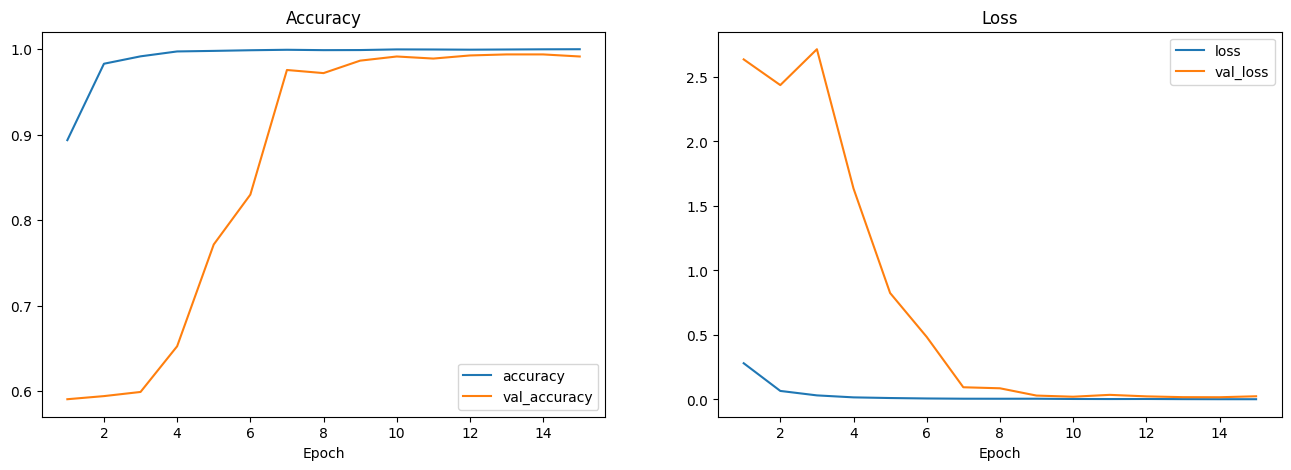

In [27]:
epoch = 15

# Make figure for subplot
fig, ax = plt.subplots(ncols=2,figsize=(16,5))

# Make plot for accuracy vs val_accuracy
ax[0].plot(range(1,epoch+1),history_final.history['accuracy'],label='accuracy')
ax[0].plot(range(1,epoch+1),history_final.history['val_accuracy'],label='val_accuracy')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epoch')

# Make plot for loss vs val_loss
ax[1].plot(range(1,epoch+1),history_final.history['loss'],label='loss')
ax[1].plot(range(1,epoch+1),history_final.history['val_loss'],label='val_loss')
ax[1].set_title('Loss')
ax[1].legend()
ax[1].set_xlabel('Epoch')

# Show figure
plt.show()

**summary** :

In [28]:
# Predict test-set

cnn_model_final.evaluate(test_gen)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 1.0000 - loss: 0.0012    


[0.0011944854632019997, 1.0]

---

**Model Summary** :

| CNN Model        | Accuracy | Val Accuracy | Loss   | Val Loss | Accuracy Difference |
|------------------|----------|--------------|--------|----------|---------------------|
| **Functional**   | 99.82    | 99.39        | 0.0049 | 0.032    | 0.43                |
| **Improved CNN** | 100.0    | 99.15        | 0.0016 | 0.024    | 0.85                |

From the table above, we can see that :
1. Training accuracy --> **`Improved Model > Functional`**
2. Validation accuracy --> **`Improved Model < Functional`**
3. Training loss --> **`Improved Model < Functional`**
4. Validation loss --> **`Improved Model < Functional`**
5. Accuracy difference --> **`Improved Model > Functional`**

In conclusion, while the Improved CNN model has a higher Accuracy, its lower Validation Accuracy suggests that it may be overfitting to the training data, making the Functional CNN model a potentially more reliable choice

## vii. **Model Inference**

**description** :

Model inference is going to be made in another notebook for a better model evaluation, so we are going to save the improved model by using joblib

In [ ]:
# Save the model using joblib
joblib.dump(cnn_model_final, 'cnn_model_final.joblib')

## **Conclusion and Recommendation**

### Conclusion

#### **EDA** :

1. There are 2 classes in the dataset : `fractured`(0) and `not fractured`(1)
2. The data is `balanced`, because the images in the data shows **50.2%** of non-fractured bone images and **49.8%** of fractured bone images
3. There are **many different images** from each one of train, test validation data. This may help to evaluate the model better in predicting the images
4. The images from the data have already been augmented with **horizontal**, **vertical flip**. There is also **rotation**, **zoom** and **shear**. This may help the model learn better.

#### **Model** :

**Model Evaluation Table** :

| CNN Model      | Accuracy | Val Accuracy | Loss   | Val Loss | Accuracy Difference |
|----------------|----------|--------------|--------|----------|---------------------|
| **Sequential** | 99.78    | 98.78        | 0.0073 | 0.054    | 1.00                |
| **Functional** | 99.82    | 99.39        | 0.0049 | 0.032    | 0.43                |

1. The Functional model outperforms the Sequential model in terms of accuracy, with a higher training accuracy (99.82% vs 99.78%) and validation accuracy (99.39% vs 98.78%).
2. The Functional model also has a lower loss and validation loss compared to the Sequential model.
3. The accuracy difference between the two models is 0.57% in favor of the Functional model, indicating a relatively small but significant improvement.

In conclusion, the **Functional CNN Model performs better** than the Sequential CNN Model.

#### **Improved Model** :

**Improved Model Evaluation Table** :

| CNN Model        | Accuracy | Val Accuracy | Loss   | Val Loss | Accuracy Difference |
|------------------|----------|--------------|--------|----------|---------------------|
| **Functional**   | 99.82    | 99.39        | 0.0049 | 0.032    | 0.43                |
| **Improved CNN** | 100.0    | 99.15        | 0.0016 | 0.024    | 0.85                |

1. The Improved CNN model has a higher training accuracy (100%) compared to the Functional model (99.82%).
2. However, the Improved CNN model has a lower validation accuracy (99.15%) compared to the Functional model (99.39%).
3. The Improved CNN model also has a lower loss and validation loss compared to the Functional model.
4. The accuracy difference between the two models is 0.42% in favor of the Functional model, indicating that the Functional model has a better performance on the validation set.

In conclusion, although the Functional CNN model is potentially a more reliable choice, we will use the **Improved CNN model** based on higher accuracy and lower loss evaluation against the test set

### **Recommendation**

#### **Model** :

Based on the Improved CNN model, the model works relatively well but might have a problem of overfitting the train set.

Here are some recommendation to reduce overfitting :
1. `Data augmentation` can be used to increase the size of the dataset and reduce overfitting. In this model we use horizonal and vertical flip, in the next model we can try widht and height shift.
2. `Dropout layers` can help prevent overfitting. Dropout randomly sets a fraction rate of input units to 0 at each update during training time, which helps to make the model more robust and prevents overfitting. In this model we use 0.5 dropout rate, in the next model we can try using 0.7 dropout rate
3. `Regularization` can help prevent overfitting by adding terms to the loss function. L1 and L2 regularization techniques can be used to reduce the complexity of the model and prevent overfitting.

#### **Business** :

Based on the successful prediction of bone fractures using a Functional ANN model, there are some business recommendation to improve patient outcomes, reduce healthcare costs, and drive innovation in the healthcare industry :

1. Healthcare providers can use the model to identify high-risk patients and provide preventive care, such as fall prevention programs, exercise programs, and medication management.
2. Insurance companies can use the model to assess the risk of bone fractures and adjust premiums accordingly.
3. Pharmaceutical companies can use the model to identify potential drug targets for the prevention and treatment of bone fractures.
4. Medical device companies can use the model to develop new products, such as wearable devices that can detect falls and alert healthcare providers.
5. Researchers can use the model to identify new risk factors for bone fractures and develop new interventions to prevent them.
6. Healthcare organizations can use the model to improve patient outcomes and reduce healthcare costs by identifying high-risk patients and providing targeted interventions.
7. Public health agencies can use the model to develop targeted interventions for high-risk populations, such as older adults and individuals with osteoporosis.
